<a href="https://colab.research.google.com/github/Cyfraice/QuantumAI/blob/main/qcnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

X shape after polynomial transformation: (1400, 21)
X shape after PCA: (1400, 16)
Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.7592 - loss: 0.5124 - val_accuracy: 0.8667 - val_loss: 0.3237
Epoch 2/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8875 - loss: 0.2937 - val_accuracy: 0.9083 - val_loss: 0.2266
Epoch 3/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9332 - loss: 0.1959 - val_accuracy: 0.9233 - val_loss: 0.1956
Epoch 4/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9439 - loss: 0.1645 - val_accuracy: 0.9467 - val_loss: 0.1412
Epoch 5/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9575 - loss: 0.1220 - val_accuracy: 0.9467 - val_loss: 0.1400
Epoch 6/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9620 - loss: 0.1053 - val_accuracy: 0.9617 - val_loss: 0.1097
Epoch 7/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9703 - loss: 0.0965 - val_accuracy: 0.9567 - val_loss: 0.1140
Epoch 8/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9771 - loss: 0.0834 - val_accuracy: 0.9600 - val_loss: 0.0954


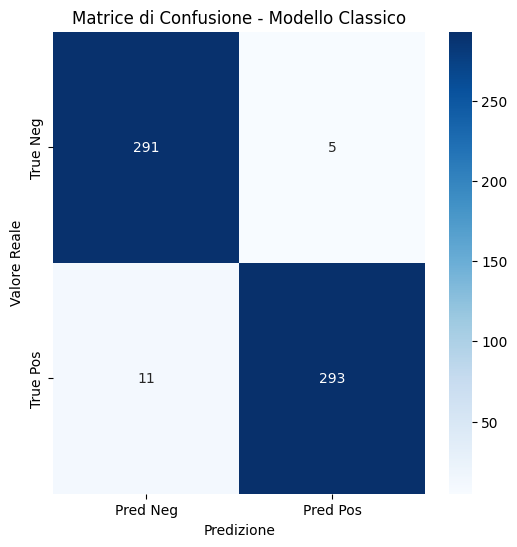

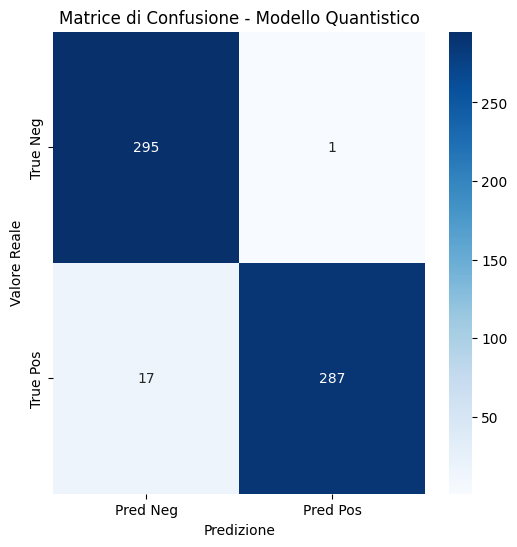

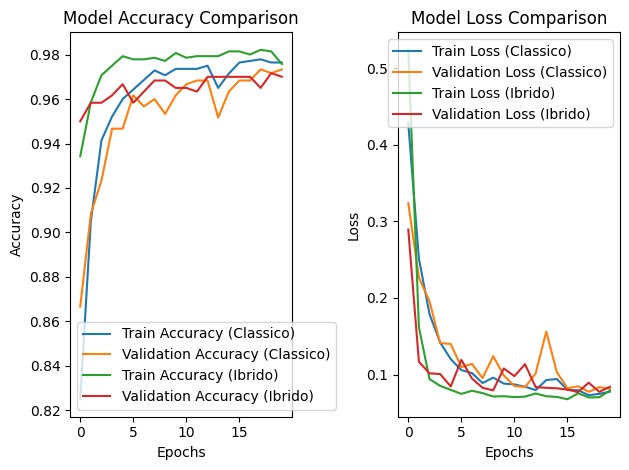

In [ ]:
#1 - CNN
# !pip install pennylane
import pennylane as qml
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.preprocessing import PolynomialFeatures
from sklearn.decomposition import PCA

#Dispositivo PennyLane
dev = qml.device("default.qubit", wires=4)


#Generare i dati delle particelle
def generate_data(num_samples=1000):
    X = []
    y = []

    for _ in range(num_samples):
        ordinato = np.random.normal(loc=0.0, scale=0.1, size=(2,))
        X.append(ordinato)
        y.append(0)  #ordinato
        caotico = np.random.normal(loc=0.5, scale=1.0, size=(2,))
        X.append(caotico)
        y.append(1)  #caotico

    return np.array(X), np.array(y)


#Creazione del circuito quantistico per ottenere le caratteristiche quantistiche
@qml.qnode(dev)
def quantum_circuit(inputs):
    for i in range(4):
        qml.Hadamard(wires=i)  # Operatore Hadamard

    qml.RZ(inputs[0], wires=0)
    qml.RZ(inputs[1], wires=1)

    #Strati di rotazione
    qml.RX(inputs[0], wires=2)
    qml.RX(inputs[1], wires=3)

    #Misura PauliZ
    return [qml.expval(qml.PauliZ(i)) for i in range(4)] + \
           [qml.expval(qml.PauliX(i)) for i in range(4)] + \
           [qml.expval(qml.PauliY(i)) for i in range(4)] + \
           [qml.expval(qml.PauliY(i)) for i in range(4)]


def generate_quantum_features(X):
    features = []
    for x in X:
        features.append(quantum_circuit(x))
    return np.array(features)


#dataset
X, y = generate_data()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)




poly = PolynomialFeatures(degree=5)
X_train_classic = poly.fit_transform(X_train)
print(f"X shape after polynomial transformation: {X_train_classic.shape}")

pca = PCA(n_components=16)
X_train_classic = pca.fit_transform(X_train_classic)
print(f"X shape after PCA: {X_train_classic.shape}")

X_test_classic = poly.transform(X_test)
X_test_classic = pca.transform(X_test_classic)




# Caratteristiche quantistiche
X_train_quantum = generate_quantum_features(X_train)
X_test_quantum = generate_quantum_features(X_test)




#CNN classica
model_classic = models.Sequential([
    layers.InputLayer(input_shape=(16,)),  # 16 valori per le *feature* quantistiche
    layers.Reshape((4, 4, 1)),
    layers.Conv2D(32, kernel_size=(2, 2), activation='relu', padding='same'),
    layers.MaxPooling2D(pool_size=(2, 2), padding='same'),
    layers.Conv2D(64, kernel_size=(2, 2), activation='relu', padding='same'),
    layers.MaxPooling2D(pool_size=(2, 2), padding='same'),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])
#Ibrida
model_quantum = models.Sequential([
    layers.InputLayer(input_shape=(16,)),  # 16 valori per le *feature* quantistiche
    layers.Reshape((4, 4, 1)),
    layers.Conv2D(32, kernel_size=(2, 2), activation='relu', padding='same'),
    layers.MaxPooling2D(pool_size=(2, 2), padding='same'),
    layers.Conv2D(64, kernel_size=(2, 2), activation='relu', padding='same'),
    layers.MaxPooling2D(pool_size=(2, 2), padding='same'),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

model_classic.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model_quantum.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


history_classic = model_classic.fit(X_train_classic, y_train, epochs=20, batch_size=32, validation_data=(X_test_classic, y_test))

history_quantum = model_quantum.fit(X_train_quantum, y_train, epochs=20, batch_size=32, validation_data=(X_test_quantum, y_test))



#Valutazione
test_acc_classic = model_quantum.evaluate(X_test_classic, y_test)

test_acc_quantum = model_quantum.evaluate(X_test_quantum, y_test)

print(f"Modello classico - Accuracy: {test_acc_classic}")

print(f"Modello quantistico - Accuracy: {test_acc_quantum}")



#visualizzazione


y_pred_classic = model_classic.predict(X_test_classic)
y_pred_classic = (y_pred_classic > 0.5).astype(int)

y_pred_quantum = model_quantum.predict(X_test_quantum)
y_pred_quantum = (y_pred_quantum > 0.5).astype(int)

print("Classification Report - Classico")
print(classification_report(y_test, y_pred_classic))

print("Classification Report - Ibrido")
print(classification_report(y_test, y_pred_quantum))







#Matrice di confusione
cm_classic = confusion_matrix(y_test, y_pred_classic)

cm_quantum = confusion_matrix(y_test, y_pred_quantum)

plt.figure(figsize=(6, 6))
sns.heatmap(cm_classic, annot=True, fmt="d", cmap="Blues", xticklabels=["Pred Neg", "Pred Pos"], yticklabels=["True Neg", "True Pos"])
plt.title("Matrice di Confusione - Modello Classico")
plt.xlabel("Predizione")
plt.ylabel("Valore Reale")
plt.show()

plt.figure(figsize=(6, 6))
sns.heatmap(cm_quantum, annot=True, fmt="d", cmap="Blues", xticklabels=["Pred Neg", "Pred Pos"], yticklabels=["True Neg", "True Pos"])
plt.title("Matrice di Confusione - Modello Quantistico")
plt.xlabel("Predizione")
plt.ylabel("Valore Reale")
plt.show()





# Accuratezza
plt.subplot(1, 2, 1)
plt.plot(history_classic.history['accuracy'], label='Train Accuracy (Classico)')
plt.plot(history_classic.history['val_accuracy'], label='Validation Accuracy (Classico)')
plt.plot(history_quantum.history['accuracy'], label='Train Accuracy (Ibrido)')
plt.plot(history_quantum.history['val_accuracy'], label='Validation Accuracy (Ibrido)')
plt.title('Model Accuracy Comparison')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Perdita
plt.subplot(1, 2, 2)
plt.plot(history_classic.history['loss'], label='Train Loss (Classico)')
plt.plot(history_classic.history['val_loss'], label='Validation Loss (Classico)')
plt.plot(history_quantum.history['loss'], label='Train Loss (Ibrido)')
plt.plot(history_quantum.history['val_loss'], label='Validation Loss (Ibrido)')
plt.title('Model Loss Comparison')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - accuracy: 0.5383 - auc: 0.8451 - loss: 0.6127 - precision: 0.5196 - recall: 0.9494 - val_accuracy: 0.9050 - val_auc: 0.9521 - val_loss: 0.4937 - val_precision: 1.0000 - val_recall: 0.7979
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8921 - auc: 0.9375 - loss: 0.4772 - precision: 1.0000 - recall: 0.7687 - val_accuracy: 0.9100 - val_auc: 0.9894 - val_loss: 0.4248 - val_precision: 1.0000 - val_recall: 0.8085
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8687 - auc: 0.9456 - loss: 0.4066 - precision: 1.0000 - recall: 0.7305 - val_accuracy: 0.8800 - val_auc: 0.9628 - val_loss: 0.3595 - val_precision: 1.0000 - val_recall: 0.7447
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8531 - auc: 0.9418 - loss: 0.3591 - precision: 1.0000 - recall: 0.7049 - val_accuracy: 0.8950 - val_auc: 0.9947 - val_loss: 0.2871 - val_precision: 1.0000 - val_recall: 0.7766
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.4994 - auc: 0.5077 - loss: 0.6931 - precision: 0.4908 - recall: 0.8437 - val_accuracy: 0.4700 - val_auc: 0.6489 - val_loss: 0.6930 - val_precision: 0.4700 - val_recall: 1.0000
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5262 - auc: 0.5007 - loss: 0.6925 - precision: 0.5262 - recall: 1.0000 - val_accuracy: 0.4700 - val_auc: 0.5106 - val_loss: 0.6929 - val_precision: 0.4700 - val_recall: 1.0000
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4913 - auc: 0.5189 - loss: 0.6927 - precision: 0.4910 - recall: 0.9301 - val_accuracy: 0.4700 - val_auc: 0.6649 - val_loss: 0.6924 - val_precision: 0.4700 - val_recall: 1.0000
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4870 - auc: 0.6557 - loss: 0.6925 - precision: 0.4870 - recall: 1.0000 - val_accuracy: 0.4700 - val_auc: 0.7713 - val_loss: 0.6922 - val_precision: 0.4700 - val_recall: 1.0000
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

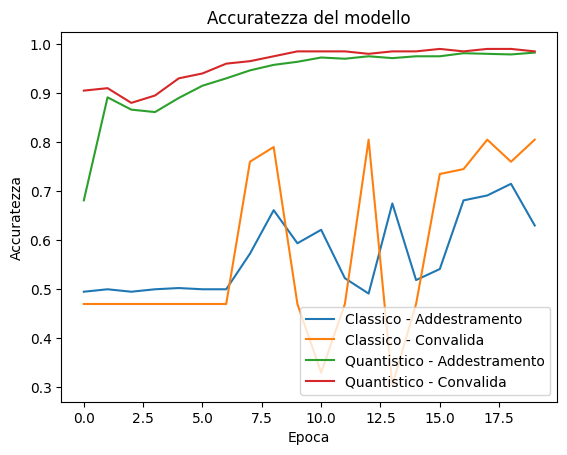

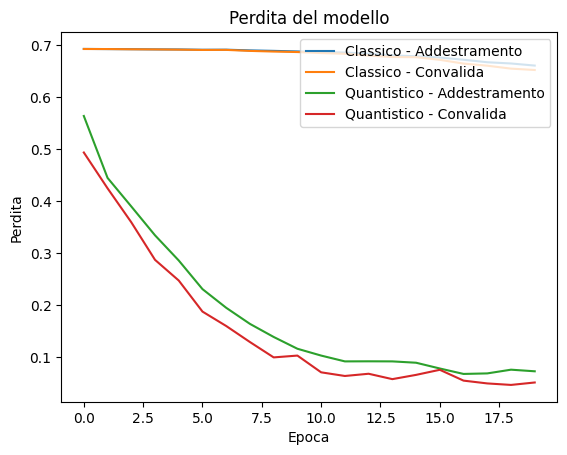

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


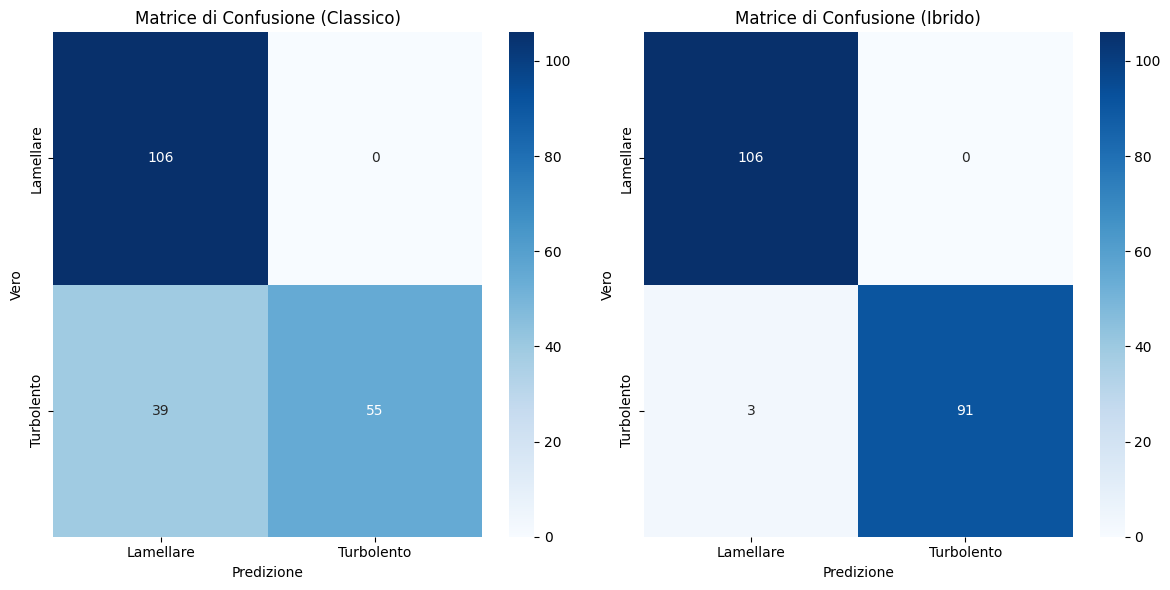

In [29]:
#!pip install pennylane
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import pennylane as qml

Lx, Ly, Lz = 10.0, 10.0, 10.0  # Dimensioni dominio
Nx, Ny, Nz = 32, 32, 32  # Griglia
dx, dy, dz = Lx / Nx, Ly / Ny, Lz / Nz
nu = 0.01  # Viscosità
dt = 0.01  # Passo temporale
steps = 100  # n passi temporali


def simulate_flow(Nx, Ny, Nz, nu, dt, steps, turbulent=False):
    u = np.zeros((Nx, Ny, Nz))
    v = np.zeros((Nx, Ny, Nz))
    w = np.zeros((Nx, Ny, Nz))

    if turbulent:
        #Rumore
        u = np.random.randn(Nx, Ny, Nz) * 0.1
        v = np.random.randn(Nx, Ny, Nz) * 0.1
        w = np.random.randn(Nx, Ny, Nz) * 0.1

        for step in range(steps):
            noise_u = np.random.randn(Nx, Ny, Nz) * 0.05  # Rumore casuale
            noise_v = np.random.randn(Nx, Ny, Nz) * 0.05
            noise_w = np.random.randn(Nx, Ny, Nz) * 0.05

            u += noise_u * dt
            v += noise_v * dt
            w += noise_w * dt
    else:
        u = np.ones((Nx, Ny, Nz)) * 0.1
        v = np.zeros((Nx, Ny, Nz))
        w = np.zeros((Nx, Ny, Nz))

    for _ in range(steps):
        grad_u = np.gradient(u, dx, axis=0), np.gradient(u, dy, axis=1), np.gradient(u, dz, axis=2)
        grad_v = np.gradient(v, dx, axis=0), np.gradient(v, dy, axis=1), np.gradient(v, dz, axis=2)
        grad_w = np.gradient(w, dx, axis=0), np.gradient(w, dy, axis=1), np.gradient(w, dz, axis=2)

        laplacian_u = np.gradient(grad_u[0], dx, axis=0) + np.gradient(grad_u[1], dy, axis=1) + np.gradient(grad_u[2], dz, axis=2)
        laplacian_v = np.gradient(grad_v[0], dx, axis=0) + np.gradient(grad_v[1], dy, axis=1) + np.gradient(grad_v[2], dz, axis=2)
        laplacian_w = np.gradient(grad_w[0], dx, axis=0) + np.gradient(grad_w[1], dy, axis=1) + np.gradient(grad_w[2], dz, axis=2)

        u += nu * laplacian_u * dt
        v += nu * laplacian_v * dt
        w += nu * laplacian_w * dt

    return u, v, w

# Dataset
def generate_dataset(samples):
    data = []
    labels = []
    for _ in range(samples):
        # Variazione casuale
        nu_varied = np.random.uniform(0.005, 0.05)  # Viscosità
        steps_varied = np.random.randint(50, 200)  # Passi temporali
        is_turbulent = np.random.rand() > 0.5

        u, v, w = simulate_flow(Nx, Ny, Nz, nu_varied, dt_varied, steps_varied, turbulent=is_turbulent)

        # Energia cinetica media
        energy = np.mean(u**2 + v**2 + w**2)
        data.append(energy)
        labels.append(1 if is_turbulent else 0)
    return np.array(data), np.array(labels)




dev = qml.device("default.qubit", wires=4)

# Circuito quantistico
@qml.qnode(dev)
def quantum_circuit(inputs):
    for i in range(4):
        qml.Hadamard(wires=i)

    qml.RZ(inputs[0], wires=0)
    qml.RZ(inputs[1], wires=1)

    qml.RX(inputs[0], wires=2)
    qml.RX(inputs[1], wires=3)

    return [qml.expval(qml.PauliZ(i)) for i in range(4)] + \
            [qml.expval(qml.PauliX(i)) for i in range(4)] + \
            [qml.expval(qml.PauliY(i)) for i in range(4)]

def generate_quantum_features(X):
    features = []
    for x in X:
        x = np.array([x, x])
        features.append(quantum_circuit(x))
    return np.array(features)




#DATI

#dataset
X, y = generate_dataset(1000)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



# Caratteristiche quantistiche
X_train_quantum = generate_quantum_features(X_train)
X_test_quantum = generate_quantum_features(X_test)



scaler = StandardScaler()
X_train_quantum_scaled = scaler.fit_transform(X_train_quantum)
X_test_quantum_scaled = scaler.transform(X_test_quantum)


def build_cnn(input_shape):
    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))

    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))

    model.add(MaxPooling2D(pool_size=(1,2)))

    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy',  metrics=["accuracy", "precision", "recall", "auc"])
    return model


X_train_reshaped = X_train.reshape(-1, 1, 1, 1)
X_test_reshaped = X_test.reshape(-1, 1, 1, 1)
X_train_quantum_reshaped = X_train_quantum_scaled.reshape(X_train_quantum_scaled.shape[0], 3, 4, 1)
X_test_quantum_reshaped = X_test_quantum_scaled.reshape(X_test_quantum_scaled.shape[0], 3, 4, 1)

input_shape_classic = (1, 1, 1)
input_shape_quantum = (3, 4, 1)


cnn_model_quantum = build_cnn(input_shape_quantum)

history_quantum = cnn_model_quantum.fit(X_train_quantum_reshaped, y_train, epochs=20, batch_size=32, validation_data=(X_test_quantum_reshaped, y_test))



X_train = X_train.reshape(-1, 1)
X_test = X_test.reshape(-1, 1)

# Classic
cnn_model = Sequential([
    Dense(64, activation='relu', input_dim=1),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=["accuracy","precision", "recall", "auc"])

history_classic = cnn_model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))



# accuratezza
plt.plot(history_classic.history['accuracy'], label='Classico - Addestramento')
plt.plot(history_classic.history['val_accuracy'], label='Classico - Convalida')
plt.plot(history_quantum.history['accuracy'], label='Quantistico - Addestramento')
plt.plot(history_quantum.history['val_accuracy'], label='Quantistico - Convalida')
plt.title('Accuratezza del modello')
plt.ylabel('Accuratezza')
plt.xlabel('Epoca')
plt.legend(loc='lower right')
plt.show()

# perdita
plt.plot(history_classic.history['loss'], label='Classico - Addestramento')
plt.plot(history_classic.history['val_loss'], label='Classico - Convalida')
plt.plot(history_quantum.history['loss'], label='Quantistico - Addestramento')
plt.plot(history_quantum.history['val_loss'], label='Quantistico - Convalida')
plt.title('Perdita del modello')
plt.ylabel('Perdita')
plt.xlabel('Epoca')
plt.legend(loc='upper right')
plt.show()



y_pred_classic = cnn_model.predict(X_test)
y_pred_classic_classes = (y_pred_classic > 0.5).astype(int)

y_pred_quantum = cnn_model_quantum.predict(X_test_quantum_reshaped)
y_pred_quantum_classes = (y_pred_quantum > 0.5).astype(int)

conf_matrix_classic = confusion_matrix(y_test, y_pred_classic_classes)
conf_matrix_quantum = confusion_matrix(y_test, y_pred_quantum_classes)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.heatmap(conf_matrix_classic, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Lamellare', 'Turbolento'], yticklabels=['Lamellare', 'Turbolento'])
plt.title('Matrice di Confusione (Classico)')
plt.xlabel('Predizione')
plt.ylabel('Vero')

plt.subplot(1, 2, 2)
sns.heatmap(conf_matrix_quantum, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Lamellare', 'Turbolento'], yticklabels=['Lamellare', 'Turbolento'])
plt.title('Matrice di Confusione (Ibrido)')
plt.xlabel('Predizione')
plt.ylabel('Vero')

plt.tight_layout()
plt.show()


